In [3]:
import scipy.io
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import scipy.stats as st
from sklearn.decomposition import FastICA

In [4]:
def load_data(file):
    mat = scipy.io.loadmat(file)
    return mat['val'][0]

In [5]:
def show_multiplot(ax, y):
    x_linspace = np.linspace(0, len(y), len(y))
    ax.plot(x_linspace, y)

In [17]:
def show_single_plot(y_beat, spike_times, spike_vals, sd_thres, filename):
    sd = np.std(y_beat, axis= 0)
    mean_sd = np.mean(sd)
    if mean_sd > sd_thres:
        fig_subset_view, ax = plt.subplots()
        ax.scatter(spike_times, spike_vals, color='red')
        ax.grid()
        ax.set_title(filename)
        show_multiplot(ax, y_beat)

In [7]:
def filter_noise(filename):
    mat = scipy.io.loadmat('heartbeat_data/'+filename)
    y=mat['val'][0]
    y_transposed = y.T # columns
    transformer = FastICA(whiten='unit-variance')
    y_transformed = transformer.fit_transform(y_transposed)
    y_beats = []

    for row in y_transformed.T:
        if min(row)< -2 or max(row)>2:
            # flip sign
            if abs(np.min(row)) > abs(np.max(row)):
                row = row * -1
            y_beats.append(row)

    y_beats = np.asarray(y_beats)
    return y_beats

In [8]:
def filter_fetus(y_beats):
    sum_first_beats = sum(scipy.signal.find_peaks(y_beats[0], height=2)[0])
    sum_second_beats = sum(scipy.signal.find_peaks(y_beats[1], height=2)[0])
    return  y_beats[0] if sum_first_beats > sum_second_beats else y_beats[1]

In [9]:
def anomalies_detection(data, cofidence):
    interval = st.t.interval(confidence= cofidence, df=len(data)-1,
              loc=np.mean(data),
              scale=st.sem(data))
    outliers = []
    for point in data:
        if point < interval[0] or point > interval[1]:
            outliers.append(point)
    return outliers

In [10]:
def set_same_height(windows, spike_vals):
    copy = windows.copy()
    for count, val in enumerate(spike_vals):
        diff = 5 - val
        copy.iloc[count] = copy.iloc[count] + diff
    return copy

In [11]:
def calc_center_window(y_beat, peak_times, spike_vals, win_size):
    half_win = int(win_size/2)
    windows = pd.DataFrame(columns = range(win_size), index=range(len(peak_times)))
    # puts None for every missing value if win_size is leading out of bounds for peaks on edges
    for count_row, peak in enumerate(peak_times): 
        min = peak - half_win
        max = peak + half_win
        count_col = 0
        for count_beat in range (min, max):
            if count_beat >= 0 and count_beat < len(y_beat):
                    windows.at[count_row , count_col] = y_beat[count_beat]
            count_col += 1
    # fill nan with column mean
    # windows.fillna(windows.mean())
    # aligned_windows = set_same_height(windows, spike_vals)
    return windows #, aligned_windows
    

In [12]:
def plot_average(y_beat, win_size, filename, sd_thres):
    sd = np.std(y_beat, axis= 0)
    mean_sd = np.mean(sd)
    if mean_sd > sd_thres:
        x = np.arange(win_size)
        est = np.mean(y_beat, axis= 0) # axis = 0: columns
        cis = (est - sd, est + sd)
        fig_subset_view, ax = plt.subplots()
        ax.grid()
        ax.plot(x,est, label="found data")
        ax.fill_between(x,cis[0],cis[1],alpha=0.2)
        ax.annotate('mean sd: '+str(f'{mean_sd:.2f}'),  xy=(1, 1),xycoords='axes fraction', fontsize=16, horizontalalignment='right', verticalalignment='top')
        ax.annotate(filename,  xy=(0, 1),xycoords='axes fraction', fontsize=16, horizontalalignment='left', verticalalignment='top')
        return True
    else: 
        return False
        

C:\Users\phili\AppData\Local\Temp\ipykernel_8224\744772075.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_subset_view, ax = plt.subplots()


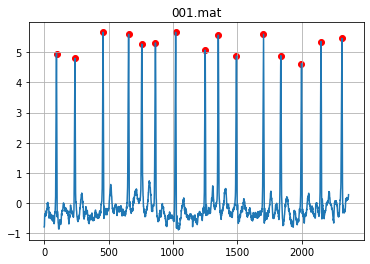

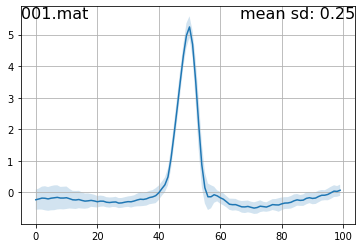

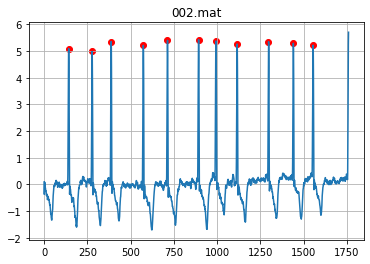

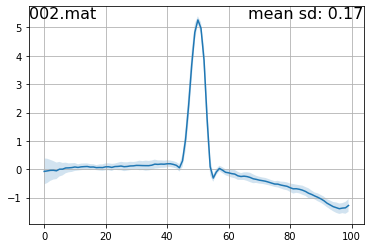

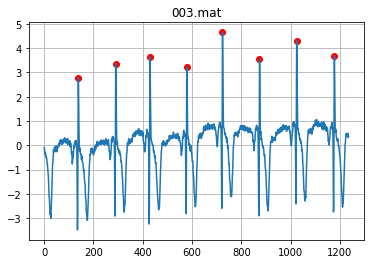

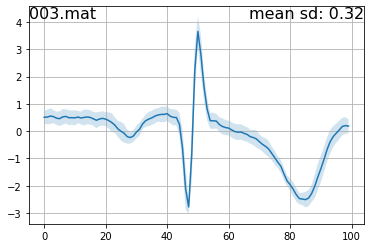

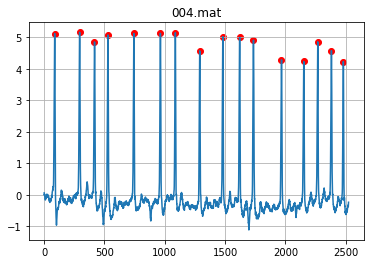

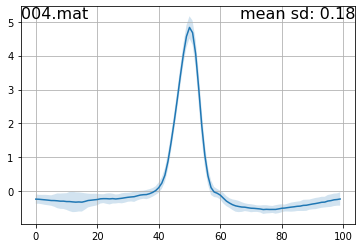

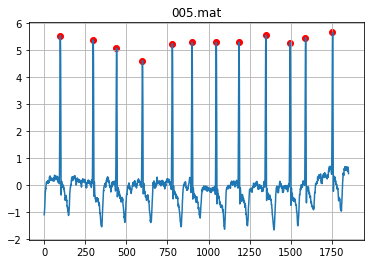

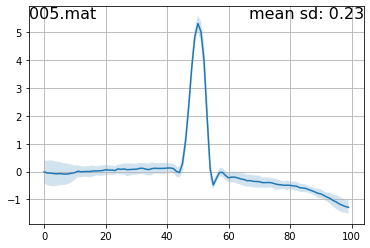

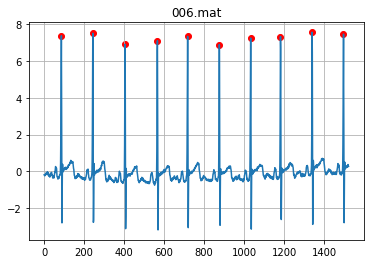

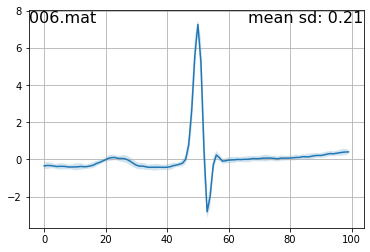

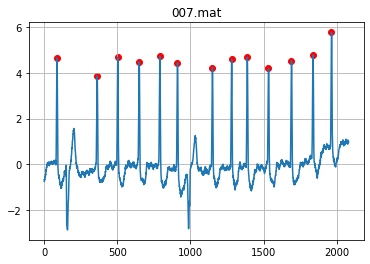

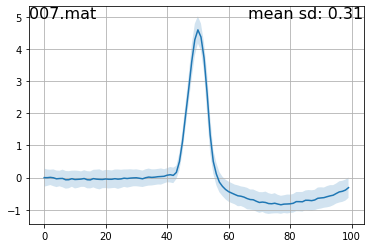

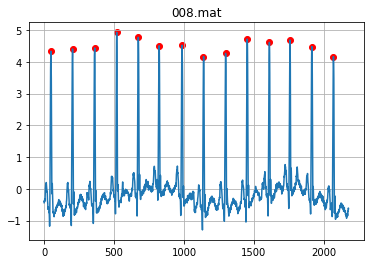

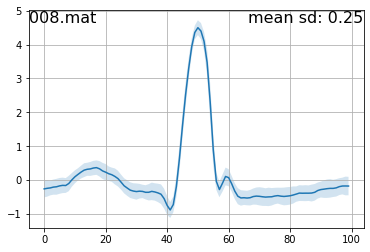

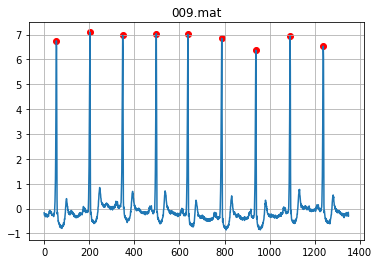

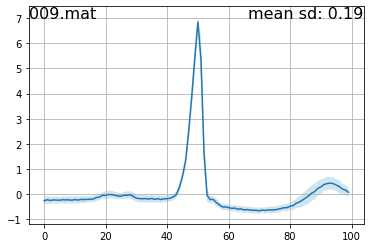

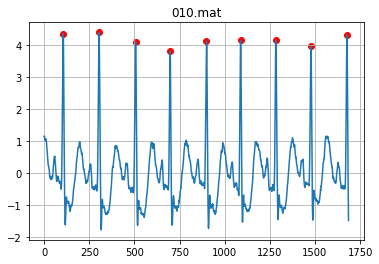

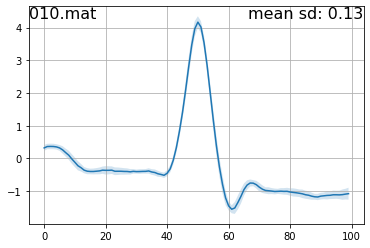

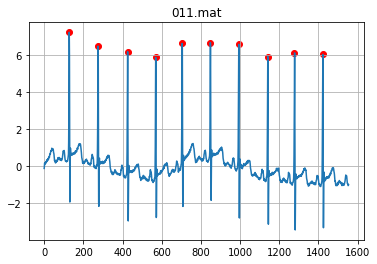

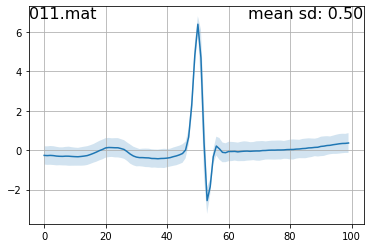

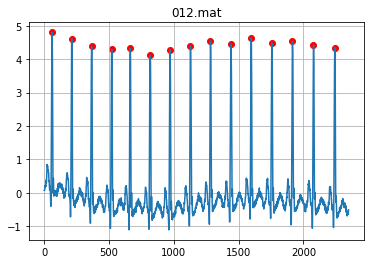

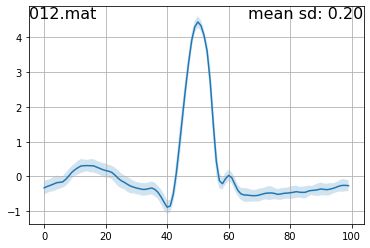

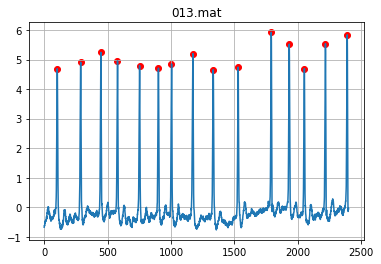

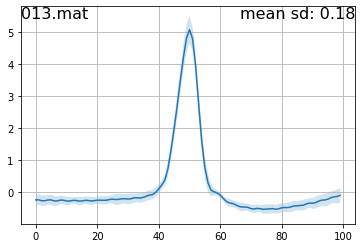

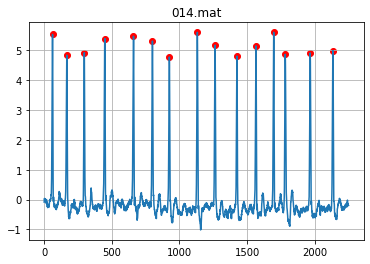

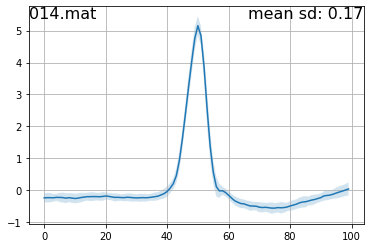

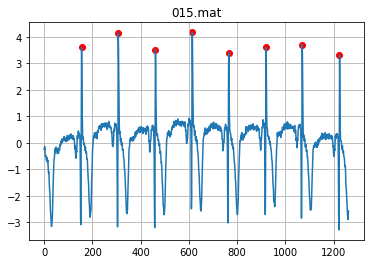

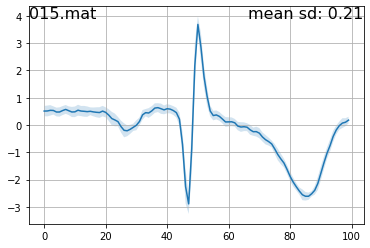

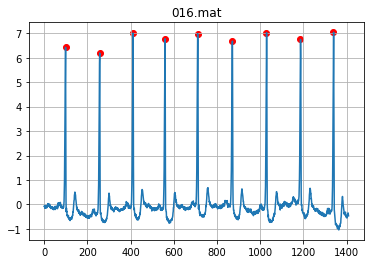

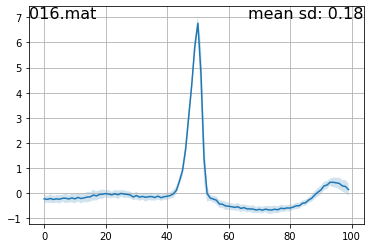

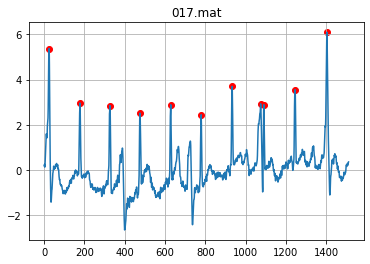

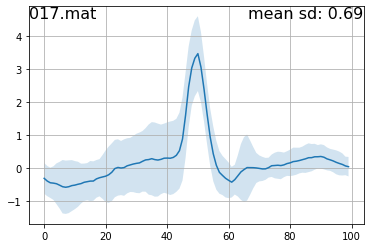

In [19]:
def main():
    start = 1
    stop = 18 #set the number of files you want to go through
    for i, filename in enumerate(os.listdir('heartbeat_data')):
        out = re.findall(r'\d+', filename)
        if int(out[0]) < start:
            continue
        if i == stop:
            break
        y_beats = filter_noise(filename)
        y_beat = filter_fetus(y_beats)
        
        # prominence = 1 means next peak can be found after follow points have a drop of at least 1
        # todo: plot single plot toether with average plot
        peaks = scipy.signal.find_peaks(y_beat, height=2, prominence=1 )
        spike_times= peaks[0]
        spike_vals = peaks[1]['peak_heights']

        win_size = 100
        sd_thres = 0.01
        windows= calc_center_window(y_beat, spike_times, spike_vals, win_size)
        aligned_windows = set_same_height(windows, spike_vals)

        show_single_plot(y_beat, spike_times, spike_vals, sd_thres, filename)

        plot_average(windows, win_size, filename, sd_thres)

        # plot_average(aligned_windows, win_size, filename, sd_thres)

   

main()